 - Setting up a test harness
 - Generating strong baseline forecasts
 - Assessing the forecastability of a time series


## Creating holdout (test) and validation datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from statsforecast import StatsForecast


In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

def forecast_bias(y_true, y_pred):
    """
    Forecast Bias (%)
    Positive -> over-forecasting
    Negative -> under-forecasting
    """
    return 100.0 * (np.sum(y_pred) - np.sum(y_true)) / np.sum(y_true)

def mase(y_true, y_pred, y_train, seasonality=7):
    naive_diff = y_train[seasonality:] - y_train[:-seasonality]
    scale = np.mean(np.abs(naive_diff))
    return np.mean(np.abs(y_true - y_pred)) / scale


from statsforecast import StatsForecast
from statsforecast.models import Naive
import time

def evaluate_model(
    model,
    model_name,
    ts_train,
    ts_val,
    _ts_train,
    _ts_val,
    freq='D',
    seasonality=7
):
    start = time.time()

    sf = StatsForecast(
        models=[model],
        freq=freq,
        n_jobs=-1,
        fallback_model=Naive()
    )

    h = len(ts_val)

    y_pred = sf.forecast(
        df=_ts_train,
        h=h,
        id_col='unique_id',
        time_col='ds',
        target_col='y'
    )

    results = _ts_val.merge(
        y_pred,
        on=['unique_id', 'ds'],
        how='left'
    )


    y_true = results['y'].values
    y_hat = results[model_name].values

    mae = mean_absolute_error(y_true, y_hat)
    rmse = np.sqrt(mean_squared_error(y_true, y_hat))
    mse = mean_squared_error(y_true, y_hat)
    mase_value = mase(
        y_true,
        y_hat,
        ts_train['sales'].values,
        seasonality=seasonality
    )
    fb = forecast_bias(y_true, y_hat)

    elapsed = time.time() - start

    return {
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MASE': mase_value,
        'Forecast Bias (%)': fb,
        'Time Elapsed': elapsed
    }

from statsforecast.models import (
    Naive,
    SeasonalNaive,
    MSTL,
    Theta,
    AutoTBATS,
    AutoARIMA,
    HoltWinters,
    SimpleExponentialSmoothing,
    Holt,
    AutoETS

)

models_dict = {
    'Naive': Naive(),
    'SeasonalNaive': SeasonalNaive(season_length=7),
    'MSTL': MSTL(season_length=7),
    'Theta': Theta(season_length=7, decomposition_type='multiplicative'),
    'AutoTBATS': AutoTBATS(
        season_length=7,
        use_trend=True,
        use_damped_trend=True
    ),
    'AutoARIMA': AutoARIMA(
        max_p=3, max_d=1, max_q=3,
        max_P=1, max_D=1, max_Q=1,
        season_length=7,
        stepwise=True
    ),
    'HoltWinters': HoltWinters(
        error_type='A',
        season_length=7
    ),
    'SES': SimpleExponentialSmoothing(
        alpha=0.2
    ),
    'Holt': Holt(
        season_length=7
    ),
   
    'AutoETS': AutoETS(
        season_length=7,
        model='ZZZ',        # let ETS choose error/trend/seasonal
        damped=True
    )

}


In [8]:
len(list(df.store_nbr.unique()))

54

In [14]:
dir='data/store-sales-time-series-forecasting'
file='train.csv'
df=pd.read_csv(f'{dir}/{file}')
df.date=pd.to_datetime(df.date)
results_list = []
for store_nbr in list(df.store_nbr.unique()):

    df_store_nbr=df[df['store_nbr']==store_nbr]
    family=list(df_store_nbr.family.unique())[0]
    
    print(store_nbr,family)
    
    df_store_nbr_family=df_store_nbr[df_store_nbr['family']==family]
    df_store_nbr_family=df_store_nbr_family.set_index('date')
    #msno.matrix(df_store_nbr_family[['sales']], freq="M")


    # Get year-month for each row
    year_month = df_store_nbr_family.index.to_period('M')

    # Identify last and second-last month
    last_month = year_month.max()
    val_month = last_month - 1

    print(last_month,val_month)

    # Test set → last month
    ts_test = df_store_nbr_family.loc[year_month == last_month, ['sales']]

    # Validation set → second last month
    ts_val = df_store_nbr_family.loc[year_month == val_month, ['sales']]

    # Train set → everything before validation month
    ts_train = df_store_nbr_family.loc[year_month < val_month, ['sales']]

    print(ts_train.shape,ts_val.shape,ts_test.shape)

    print(ts_train.index.min(), "→", ts_train.index.max())
    print(ts_val.index.min(), "→", ts_val.index.max())
    print(ts_test.index.min(), "→", ts_test.index.max())

    _ts_train = (
        ts_train
        .reset_index()
        .rename(columns={
            'date': 'ds',
            'sales': 'y'
        })
    )

    _ts_train['unique_id'] = f'store_{store_nbr}_{family}'


    _ts_val = (
        ts_val
        .reset_index()
        .rename(columns={
            'date': 'ds',
            'sales': 'y'
        })
    )

    _ts_val['unique_id'] = f'store_{store_nbr}_{family}'


    

    for model_name, model in models_dict.items():
        #print(f'Running {model_name}...')
        metrics = evaluate_model(
            model=model,
            model_name=model_name,
            ts_train=ts_train,
            ts_val=ts_val,
            _ts_train=_ts_train,
            _ts_val=_ts_val,
            freq='D',
            seasonality=7
        )
        metrics['store_nbr']=store_nbr
        results_list.append(metrics)

    summary_df = pd.DataFrame(results_list)
    #summary_df = summary_df.sort_values('MASE')
    summary_df.to_csv(f'forecasts/{family}_preds.csv',index=False)    

    

1 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


10 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


11 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


12 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


13 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


14 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


15 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


16 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


17 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


18 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


19 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


2 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


20 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


21 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


22 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


23 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


24 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


25 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


26 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


27 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


28 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


29 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


3 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


30 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


31 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


32 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


33 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


34 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


35 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


36 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


37 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


38 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


39 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


4 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


40 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


41 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


42 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


43 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


44 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


45 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


46 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


47 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


48 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


49 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


5 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


50 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


51 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


52 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


53 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


54 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


6 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


7 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


8 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


9 AUTOMOTIVE
2017-08 2017-07
(1638, 1) (31, 1) (15, 1)
2013-01-01 00:00:00 → 2017-06-30 00:00:00
2017-07-01 00:00:00 → 2017-07-31 00:00:00
2017-08-01 00:00:00 → 2017-08-15 00:00:00


/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/statsforecast/tbats.py:938: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


In [28]:
summary_df.store_nbr.unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9])

### Which model is consistently good across store

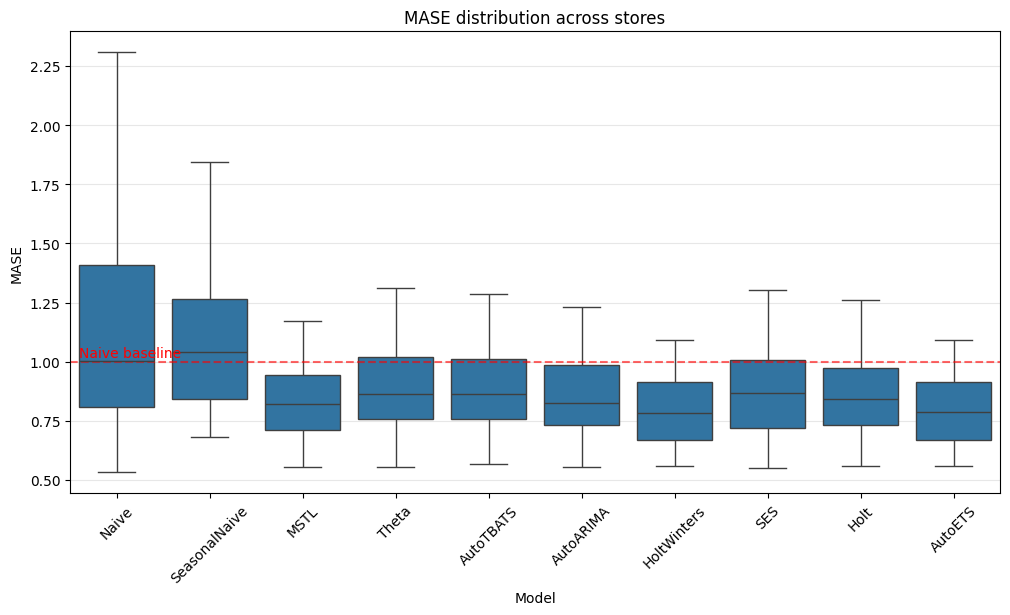

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

sns.boxplot(
    data=summary_df,
    x='Model',
    y='MASE',
    showfliers=False
)

plt.axhline(1.0, color='red', linestyle='--', alpha=0.6)
plt.text(-0.4, 1.02, 'Naive baseline', color='red')

plt.xticks(rotation=45)
plt.title('MASE distribution across stores')
plt.ylabel('MASE')
plt.grid(True, axis='y', alpha=0.3)
plt.show()

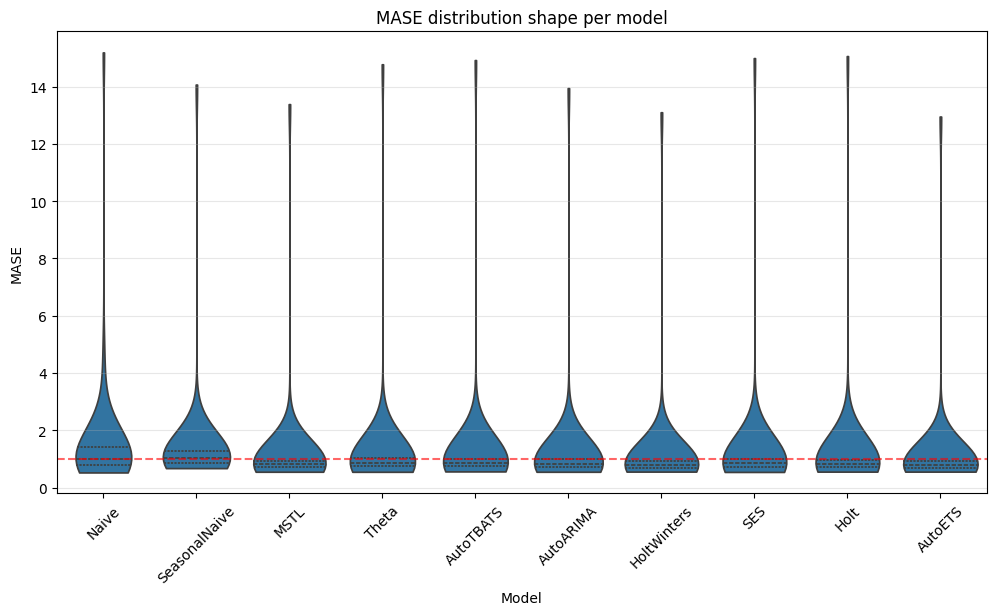

In [34]:
plt.figure(figsize=(12, 6))

sns.violinplot(
    data=summary_df,
    x='Model',
    y='MASE',
    inner='quartile',
    cut=0
)

plt.axhline(1.0, color='red', linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.title('MASE distribution shape per model')
plt.grid(True, axis='y', alpha=0.3)
plt.show()

In [31]:
summary_df[['Model','store_nbr','MASE']]

,Model,store_nbr,MASE
0,Naive,1,2.401624
1,SeasonalNaive,1,1.361746
2,MSTL,1,0.893636
3,Theta,1,0.879471
4,AutoTBATS,1,0.870405
...,...,...,...
535,AutoARIMA,9,0.641130
536,HoltWinters,9,0.583856
537,SES,9,0.624145
538,Holt,9,0.654646


In [16]:
best_per_store = (
    summary_df
    .loc[summary_df.groupby('store_nbr')['MASE'].idxmin()]
)

In [35]:
#best_per_store

In [19]:
model_win_counts = (
    best_per_store['Model']
    .value_counts()
    .reset_index()
)

model_win_counts.columns = ['Model', 'Num_Wins']
model_win_counts

,Model,Num_Wins
0,HoltWinters,19
1,MSTL,12
2,SES,8
3,AutoETS,5
4,Naive,3
5,AutoTBATS,2
6,Theta,2
7,Holt,1
8,AutoARIMA,1
9,SeasonalNaive,1


In [20]:
models_to_compare = ['HoltWinters', 'MSTL']

df_cmp = summary_df[summary_df['Model'].isin(models_to_compare)].copy()

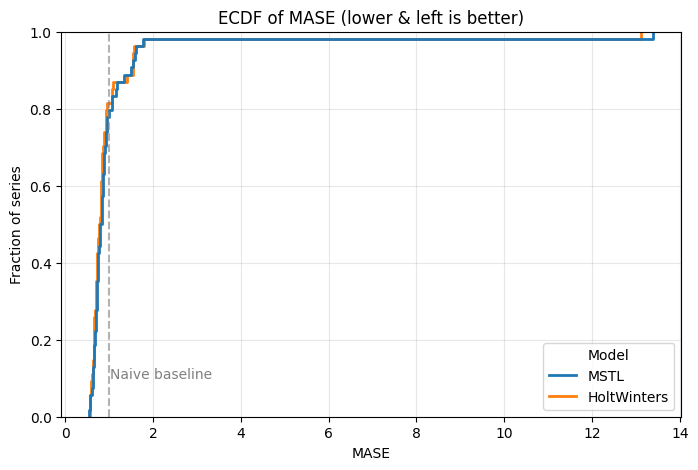

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))

sns.ecdfplot(
    data=df_cmp,
    x='MASE',
    hue='Model',
    linewidth=2
)

plt.axvline(1.0, color='gray', linestyle='--', alpha=0.6)
plt.text(1.02, 0.1, 'Naive baseline', color='gray')

plt.title('ECDF of MASE (lower & left is better)')
plt.xlabel('MASE')
plt.ylabel('Fraction of series')
plt.grid(True, alpha=0.3)
plt.show()

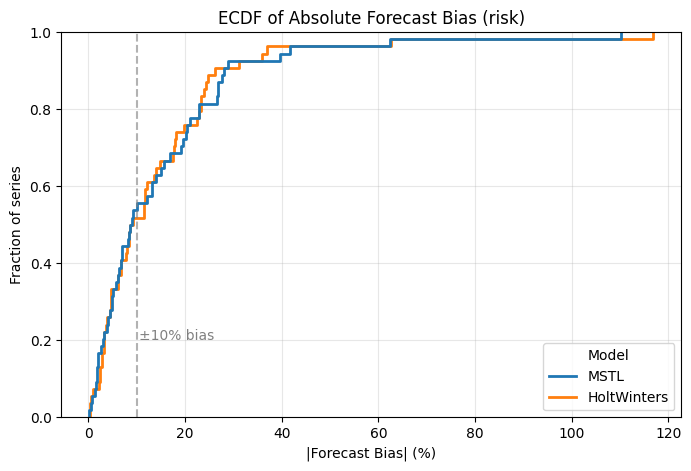

In [24]:
df_cmp['Abs_Bias'] = df_cmp['Forecast Bias (%)'].abs()

plt.figure(figsize=(8, 5))

sns.ecdfplot(
    data=df_cmp,
    x='Abs_Bias',
    hue='Model',
    linewidth=2
)

plt.axvline(10, color='gray', linestyle='--', alpha=0.6)
plt.text(10.5, 0.2, '±10% bias', color='gray')

plt.title('ECDF of Absolute Forecast Bias (risk)')
plt.xlabel('|Forecast Bias| (%)')
plt.ylabel('Fraction of series')
plt.grid(True, alpha=0.3)
plt.show()

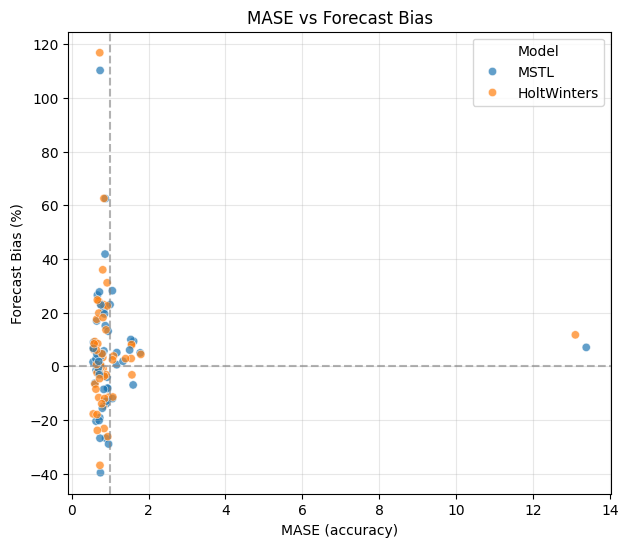

In [25]:
plt.figure(figsize=(7, 6))

sns.scatterplot(
    data=df_cmp,
    x='MASE',
    y='Forecast Bias (%)',
    hue='Model',
    alpha=0.7
)

plt.axvline(1.0, color='gray', linestyle='--', alpha=0.6)
plt.axhline(0.0, color='gray', linestyle='--', alpha=0.6)

plt.title('MASE vs Forecast Bias')
plt.xlabel('MASE (accuracy)')
plt.ylabel('Forecast Bias (%)')
plt.grid(True, alpha=0.3)
plt.show()